In [2]:
# Import required libraries and dependencies
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import hvplot.pandas
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno 

from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss
from tabulate import tabulate


# 1. Loading the Dataset from CSV

In [3]:
# Load the data into a Pandas DataFrame
df5 = pd.read_csv("heart_2022_cleaned.csv")
# Display sample data
df5

,Sex,Age,Race,BMI,GenHealth,PhysicalHealth,MentalHealth,PhysicalActivity,ChestScan,SleepHours,...,ECigaretteUsage,Drinking,HeartAttack,Angina,Stroke,Asthma,SkinCancer,Depressed,KidneyDisease,Diabetes
0,0,12,0,26.57,4,0.0,0.0,0,0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,0,7,0,25.61,3,2.0,3.0,1,0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,0,4,0,21.77,1,2.0,0.0,1,1,9.0,...,0,1,0,0,0,0,1,0,0,0
3,1,12,0,26.08,0,1.0,0.0,0,0,7.0,...,0,0,1,0,1,0,1,0,0,1
4,0,12,1,22.96,3,0.0,0.0,1,0,7.0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318929,1,9,3,29.86,2,0.0,15.0,1,0,7.0,...,0,1,0,0,1,0,1,0,0,1
318930,1,2,0,31.19,2,0.0,0.0,1,0,8.0,...,0,1,0,0,0,0,1,0,0,0
318931,0,6,1,28.66,4,2.0,2.0,1,0,7.0,...,0,0,0,0,0,0,1,0,0,0
318932,1,10,1,32.55,3,0.0,0.0,0,1,5.0,...,0,0,1,0,0,1,1,0,0,0


# 5. Machine Learning

In [4]:
# Define features set X
X = df5.drop("HeartAttack", axis=1)
# Define target vector y
y = df5["HeartAttack"].values

##### Using MinMaxScaler() and SMOTE to deal with Imbalanced Data

In [5]:
# SMOTE for Resampling to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### Split the Resampled data into Training, Validation and Test sets. The validation set is used for tuning hyperparameters and early stopping.

In [6]:
# Split the data into training, validation, and test using train_test_split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, 
    y_resampled, 
    stratify=y_resampled,  # to maintain the same proportion of classes in both train and test sets
    test_size=0.3,
    random_state=78
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    stratify=y_temp,
    test_size=0.5,
    random_state=78
)

#### Standardize the features using StandardScaler()

In [7]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler and Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Define the Models and their hyperparameters
#### Models: [1] RandomForests, [2] Logistic, [3] XGBoost, [4] Gradient Boosting

In [10]:
# Define models and their hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=78),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=78, max_iter=1000),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', None],
            'C': [0.1, 1, 10, 100]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=78, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=78),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

### Train and evaluate each model


In [12]:
# Train and evaluate each model
results = []

In [13]:
for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        estimator=model_info['model'],
        param_grid=model_info['params'],
        cv=3,  
        n_jobs=-1,
        scoring='accuracy',
        verbose=2
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    val_predictions = best_model.predict(X_val_scaled)
    val_acc_score = accuracy_score(y_val, val_predictions)
    
    # Evaluate on test set
    test_predictions = best_model.predict(X_test_scaled)
    
    # Predictions and probabilities
    y_train_pred = best_model.predict(X_train_scaled)
    y_val_pred = best_model.predict(X_val_scaled)
    y_test_pred = best_model.predict(X_test_scaled)
    
    y_train_prob = best_model.predict_proba(X_train_scaled)[:, 1]
    y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]
    y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate losses
    train_loss = log_loss(y_train, y_train_prob)
    val_loss = log_loss(y_val, y_val_prob)
    test_loss = log_loss(y_test, y_test_prob)
    
    # Calculate errors
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, test_predictions)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    
    print(f"\n{model_name} Results")
    print("Confusion Matrix")
    print(cm_df)
    print(f"Accuracy Score: {accuracy_score(y_test, test_predictions)}")
    print("Classification Report")
    print(classification_report(y_test, test_predictions))
    
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Validation Accuracy': val_acc_score,
        'Test Accuracy': accuracy_score(y_test, test_predictions),
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
        'Test Loss': test_loss,
        'Train Error': train_error,
        'Validation Error': val_error,
        'Test Error': test_error
    })

Training RandomForest...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  40.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  41.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  41.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  42.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  41.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  42.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total

/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....................................C=1, penalty=l2; total time=   0.2s
[CV] END ...................................C=10, penalty=l1; total time=   0.0s
[CV] END ...................................C=10, penalty=l1; total time=   0.0s
[CV] END ................................C=0.1, penalty=None; total time=   0.2s
[CV] END ................................C=0.1, penalty=None; total time=   0.3s
[CV] END ...........................C=10, penalty=elasticnet; total time=   0.0s
[CV] END ................................C=0.1, penalty=None; total time=   0.3s
[CV] END ..................................C=1, penalty=None; total time=   0.2s
[CV] END ...........................C=10, penalty=elasticnet; total time=   0.0s
[CV] END ...................................C=10, penalty=l2; total time=   0.2s
[CV] END ...........................C=10, penalty=elasticnet; total time=   0.0s
[CV] END ..................................C=1, penalty=None; total time=   0.3s
[CV] END ...................

/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/hatkiet/anaco

[CV] END .................................C=10, penalty=None; total time=   0.2s
[CV] END .................................C=10, penalty=None; total time=   0.2s
[CV] END .................................C=10, penalty=None; total time=   0.2s
[CV] END ..................................C=100, penalty=l2; total time=   0.2s
[CV] END ..................................C=100, penalty=l2; total time=   0.2s
[CV] END ..................................C=100, penalty=l2; total time=   0.2s
[CV] END ................................C=100, penalty=None; total time=   0.2s
[CV] END ................................C=100, penalty=None; total time=   0.2s
[CV] END ................................C=100, penalty=None; total time=   0.2s

LogisticRegression Results
Confusion Matrix
          Predicted 0  Predicted 1
Actual 0        37631         7667
Actual 1         9701        35598
Accuracy Score: 0.8082938728655474
Classification Report
              precision    recall  f1-score   support

         

In [14]:
# Display results in a tabular format
results_df = pd.DataFrame(results)
results_df

,Model,Best Params,Validation Accuracy,Test Accuracy,Train Loss,Validation Loss,Test Loss,Train Error,Validation Error,Test Error
0,RandomForest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.970838,0.971026,0.027292,0.095933,0.096938,0.000102,0.029162,0.028974
1,LogisticRegression,"{'C': 0.1, 'penalty': 'l2'}",0.807431,0.808294,0.413183,0.413974,0.411717,0.192926,0.192569,0.191706
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.967217,0.967372,0.071676,0.089575,0.089809,0.025256,0.032783,0.032628
3,GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.968431,0.968056,0.064849,0.088926,0.087608,0.022645,0.031569,0.031944


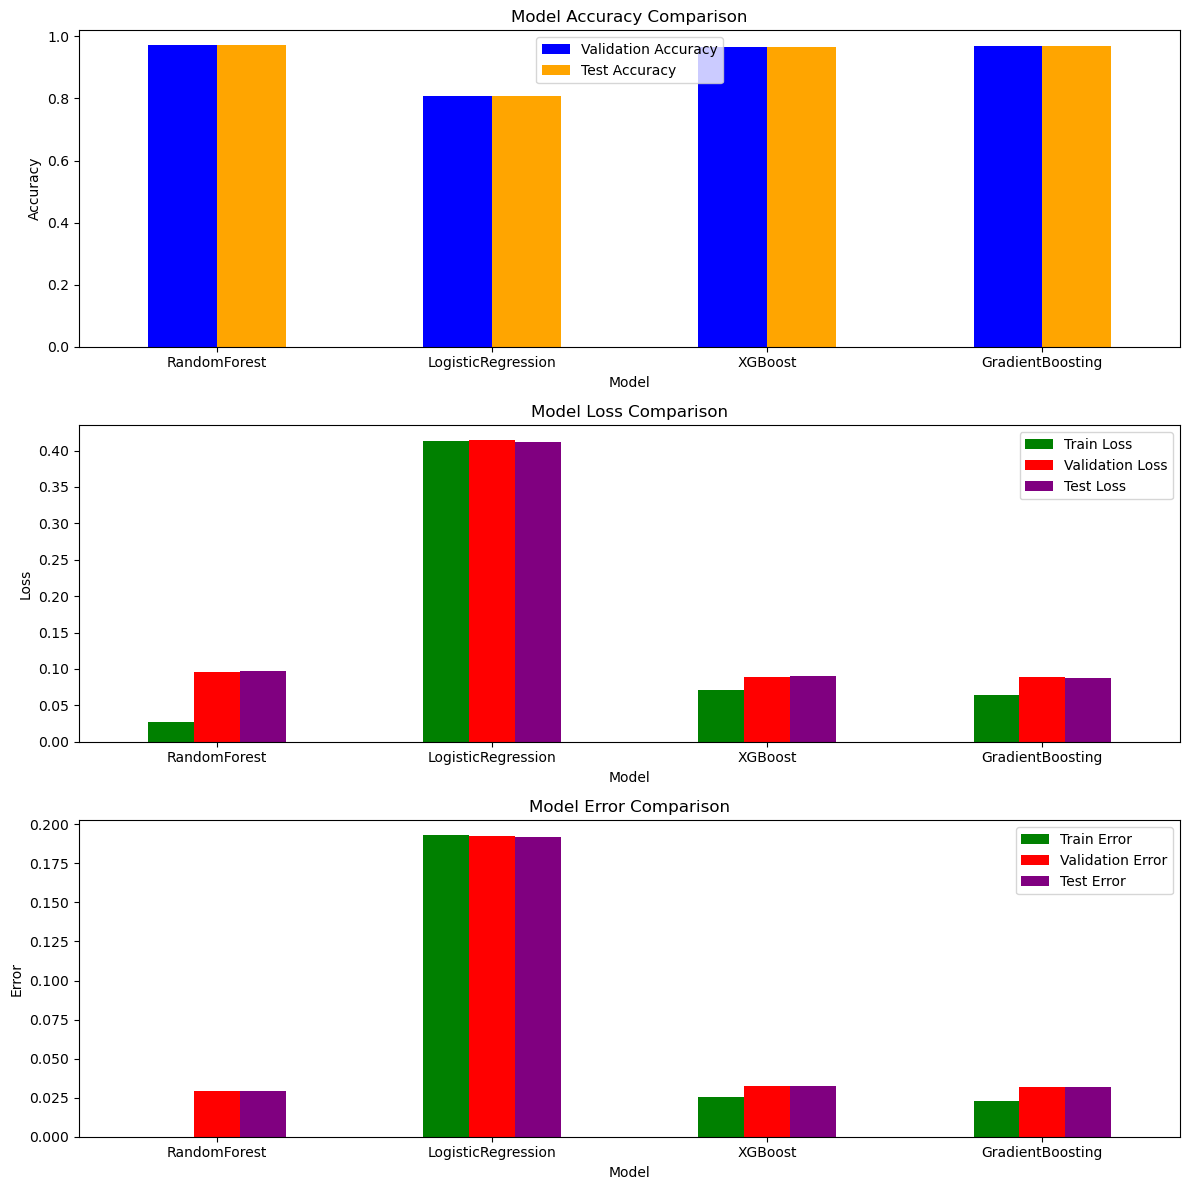

In [17]:
# Plotting model performance metrics
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plotting accuracy
results_df.plot(kind='bar', x='Model', y=['Validation Accuracy', 'Test Accuracy'], ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plotting loss
results_df.plot(kind='bar', x='Model', y=['Train Loss', 'Validation Loss', 'Test Loss'], ax=axes[1], color=['green', 'red', 'purple'])
axes[1].set_title('Model Loss Comparison')
axes[1].set_ylabel('Loss')
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plotting error
results_df.plot(kind='bar', x='Model', y=['Train Error', 'Validation Error', 'Test Error'], ax=axes[2], color=['yellow', 'cyan', 'lime'])
axes[2].set_title('Model Error Comparison')
axes[2].set_ylabel('Error')
axes[2].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()